In [5]:
import gym
import numpy as np
import matplotlib.pyplot as plt

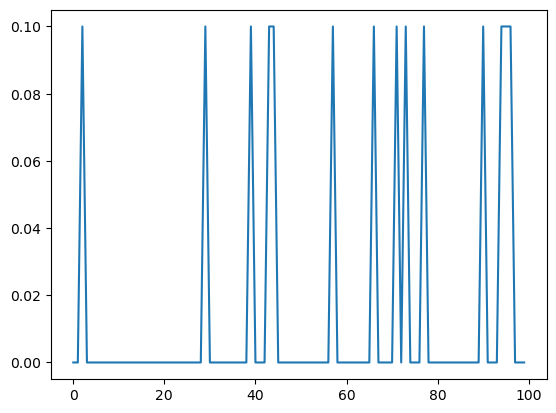

In [25]:
env = gym.make('FrozenLake-v1')
n_games = 1000
win_pct = []
scores = []

for i in range(n_games):
    done = False
    obs = env.reset()
    score = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, truncated, info = env.step(action)
        score += reward
        done = done or truncated  # Ensure the loop exits if the episode is truncated
    scores.append(score)
    if i % 10 == 0:
        average = np.mean(scores[-10:])
        win_pct.append(average)

plt.plot(win_pct)
plt.show()

$Q(s, a; \theta) = \mathbb{E} \left[ r_t + \gamma \max_{a'} Q(s', a'; \theta') \middle| s, a \right]$

* Q 是状态 s 和动作 a 下的 Q 值，参数 θ 表示 Q 网络的参数。
* $r_t$ 是当前步的奖励。
* $\gamma$ 是折扣因子，让未来的收益打折
* $max_{a'} Q$ 是下一步状态 $s'$中最大的 Q 值，$a'$ 是 $s'$ 中所有动作

Q 度量的是当前状态和动下下，且未来总用最优动作带来的回报折现

学习更新的方法

$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_t + \gamma \max_{a'} Q(s_{t+1}, a') - Q(s_t, a_t) \right)$